In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import snowballstemmer

import matplotlib.font_manager as fm
from sklearn.preprocessing import MinMaxScaler
import re
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, LassoCV
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from collections import Counter

import pickle
from sklearn.dummy import DummyRegressor



Development

In [2]:
user_df = pd.read_csv("user_df_filtered_nplus.csv")

In [3]:
user_df.head(100)

,Unnamed: 0,Game Name,Review,Rating
0,0,Wolfenstein: The Old Blood,Decided to play some culturally and historical...,70
1,1,Wolfenstein: The Old Blood,if you are very hungry for more neo-wolfenstei...,70
2,2,Wolfenstein: The Old Blood,Slightly less fun version of the New Order,60
3,3,Wolfenstein: The Old Blood,Part 1 is a tad of a slog by comparison with p...,70
4,4,Wolfenstein: The Old Blood,This was a relatively short game. I beat the g...,60
...,...,...,...,...
95,95,Wolfenstein: The Old Blood,why is it like 4 hours long,60
96,96,Wolfenstein: The Old Blood,Playtime: 5:30 HoursAt first this standalone D...,70
97,97,Wolfenstein: The Old Blood,Most of what can be said about Wolfenstein: Th...,70
98,98,Wolfenstein: The Old Blood,A good prequel toWolfenstein: The New Ordertha...,80


In [4]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+[^\s]*', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text.strip()



# Define regex patterns for extracting emojis and emoticons
emoji_pattern = re.compile(
    "[\U0001F600-\U0001F64F"  
    "\U0001F300-\U0001F5FF"  
    "\U0001F680-\U0001F6FF"  
    "\U0001F700-\U0001F77F"  
    "\U0001F780-\U0001F7FF"  
    "\U0001F800-\U0001F8FF"  
    "\U0001F900-\U0001F9FF"  
    "\U0001FA00-\U0001FA6F"  
    "\U0001FA70-\U0001FAFF]",  
    flags=re.UNICODE
)
emoticon_pattern = re.compile(r"[:;=8xX][-oO']?[\)\(DdpP/\\]")

# Function to extract emojis from text
def extract_emojis(text):
    return " ".join(emoji_pattern.findall(str(text)))

# Function to extract emoticons from text
def extract_emoticons(text):
    return " ".join(emoticon_pattern.findall(str(text)))

# Apply emoji and emoticon extraction to the 'Review' column
user_df["Emoticons"] = user_df["Review"].apply(extract_emoticons)
user_df["Emojis"] = user_df["Review"].apply(extract_emojis)

# Initialize Porter Stemmer and Snowball Stemmer for English
ps = PorterStemmer()
stemmer = snowballstemmer.stemmer("english")

# Function to perform stemming on text
def stem_text(text):
    words = re.findall(r'\w+', text.lower())  # Tokenize text (keep only word characters)
    stemmed_words = stemmer.stemWords(words)  # Apply stemming
    return " ".join(stemmed_words)

# Clean and preprocess text data
user_df["Clean_Review"] = user_df["Review"].apply(clean_text)  # Apply text cleaning
user_df["Clean_Review"] = user_df["Clean_Review"].apply(stem_text)  # Apply stemming

# Append extracted emojis and emoticons to the cleaned text
user_df["Clean_Review"] = (
    user_df["Clean_Review"] + " " +
    user_df["Emojis"] + " " +
    user_df["Emoticons"]
).str.strip()  # Ensure no extra spaces

In [5]:
user_df[0:100]

,Unnamed: 0,Game Name,Review,Rating,Emoticons,Emojis,Clean_Review
0,0,Wolfenstein: The Old Blood,Decided to play some culturally and historical...,70,xp,,decid to play some cultur and histor relev med...
1,1,Wolfenstein: The Old Blood,if you are very hungry for more neo-wolfenstei...,70,8/,,if you are veri hungri for more neowolfenstein...
2,2,Wolfenstein: The Old Blood,Slightly less fun version of the New Order,60,,,slight less fun version of the new order
3,3,Wolfenstein: The Old Blood,Part 1 is a tad of a slog by comparison with p...,70,,,part is a tad of a slog by comparison with par...
4,4,Wolfenstein: The Old Blood,This was a relatively short game. I beat the g...,60,,,this was a relat short game i beat the game on...
...,...,...,...,...,...,...,...
95,95,Wolfenstein: The Old Blood,why is it like 4 hours long,60,,,whi is it like hour long
96,96,Wolfenstein: The Old Blood,Playtime: 5:30 HoursAt first this standalone D...,70,,,playtim hoursat first this standalon dlc was t...
97,97,Wolfenstein: The Old Blood,Most of what can be said about Wolfenstein: Th...,70,xp xp,,most of what can be said about wolfenstein the...
98,98,Wolfenstein: The Old Blood,A good prequel toWolfenstein: The New Ordertha...,80,xp,,a good prequel towolfenstein the new orderthat...


In [6]:
X_temp, _, y_train, y_test = train_test_split(user_df[["Clean_Review"]],
                                              user_df["Rating"],
                                              test_size=0.2,
                                              random_state=42)
print(X_temp)
scaler_y = MinMaxScaler()
y_train_normalized = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_normalized = scaler_y.transform(y_test.values.reshape(-1, 1))

                                             Clean_Review
106890  eh this one never realli grab my attent like t...
92180   this game made me buy a switch and even with i...
13278   great gamehistori is veri awesomegameplay suck...
89862   seem veri fun later on but i need to have the ...
170301                great and quick littl adventur game
...                                                   ...
119879  gris should be a home run for me it a game wit...
103694  write review year after first playthi was and ...
131932  such insan fun yes the combat can get repetit ...
146867  cyberpunk has some issu some have been fix ret...
121958  incred color and design veri fun and welcom to...

[203519 rows x 1 columns]


In [7]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, 
                                   ngram_range=(1, 3), 
                                   stop_words='english', 
                                   min_df=5, 
                                   max_df=0.95)
X_tfidf_train = tfidf_vectorizer.fit_transform(X_temp["Clean_Review"])
X_tfidf_test = tfidf_vectorizer.transform(user_df.loc[y_test.index, "Clean_Review"])

In [8]:
ngram_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 3), stop_words='english', min_df=5, max_df=0.95)
X_ngrams_train = ngram_vectorizer.fit_transform(X_temp["Clean_Review"])
X_ngrams_test = ngram_vectorizer.transform(user_df.loc[y_test.index, "Clean_Review"])

In [9]:
# Define an emoji regex pattern for feature extraction using CountVectorizer
emoji_pattern2 = (
    "[\U0001F600-\U0001F64F"  # Emoticons
    "\U0001F300-\U0001F5FF"  # Symbols & pictographs
    "\U0001F680-\U0001F6FF"  # Transport & map symbols
    "\U0001F700-\U0001F77F"  # Alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric shapes
    "\U0001F800-\U0001F8FF"  # Supplemental arrows
    "\U0001F900-\U0001F9FF"  # Supplemental symbols
    "\U0001FA00-\U0001FA6F"  # Chess symbols
    "\U0001FA70-\U0001FAFF]")  # More supplemental symbols

# Initialize CountVectorizer for extracting emoji features
emoji_vectorizer = CountVectorizer(
    max_features=500,  # Limit to top 500 most frequent features
    token_pattern=emoji_pattern2,  # Use the defined emoji pattern
    max_df=1.0  # Use all available data
)

# Extract emoji features from the cleaned reviews
emoji_train_dfm = emoji_vectorizer.fit_transform(X_temp["Clean_Review"])
emoji_test_dfm = emoji_vectorizer.transform(user_df.loc[y_test.index, "Clean_Review"])

# Initialize CountVectorizer for extracting emoticon features
emoticon_vectorizer = CountVectorizer(
    max_features=500,  # Limit to top 500 most frequent emoticons
    token_pattern=r"[:;=8xX][-oO']?[\)\(DdpP/\\]",  # Recognize emoticons
    min_df=1,  # Minimum document frequency
    max_df=0.9  # Maximum document frequency
)

# Extract emoticon features from the cleaned reviews
emoticon_train_dfm = emoticon_vectorizer.fit_transform(X_temp["Clean_Review"])
emoticon_test_dfm = emoticon_vectorizer.transform(user_df.loc[y_test.index, "Clean_Review"])


In [10]:
# Retrieve the extracted emoji vocabulary
emoji_features = emoji_vectorizer.get_feature_names_out()
print("Extracted Emoji features:", emoji_features[:20])  # Display only the first 20 extracted emoji features

# Retrieve the extracted emoticon vocabulary
emoticon_features = emoticon_vectorizer.get_feature_names_out()
print("Extracted Emoticon features:", emoticon_features[:20])  # Display only the first 20 extracted emoticon features

Extracted Emoji features: ['🌄' '🌅' '🌆' '🌈' '🌊' '🌕' '🌖' '🌙' '🌞' '🌟' '🌦' '🌫' '🌱' '🌲' '🌳' '🌴' '🍂' '🍃'
 '🍄' '🍆']
Extracted Emoticon features: ['8(' '8)' '8-p' '8/' '8\\' '8d' '8op' '8p' ":'(" ":')" ":'d" ':(' ':)'
 ':-(' ':-)' ':-d' ':-p' ':/' ':\\' ':d']


In [11]:
# Function to tokenize a list of reviews using simple preprocessing
def tokenize_reviews(reviews):
    return [simple_preprocess(review) for review in reviews]

# Tokenize the "Clean_Review" column from user_df
tokenized_reviews = tokenize_reviews(user_df["Clean_Review"].tolist())

# Train a Word2Vec model using the tokenized reviews
model = Word2Vec(sentences=tokenized_reviews,  # Input tokenized sentences
                 vector_size=100,  # Dimensionality of word embeddings
                 window=5,  # Context window size for words
                 min_count=5,  # Minimum word frequency to be considered
                 workers=4)  # Number of CPU cores to use

# Function to compute sentence embeddings by averaging word vectors
def get_sentence_embedding(review, model, vector_size=100):
    words = simple_preprocess(review)  # Tokenize the review
    # Retrieve word vectors for words present in the Word2Vec model
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    # Return a zero vector if no words from the review are in the model
    if len(word_vectors) == 0:
        return np.zeros(vector_size)
    # Compute the mean of word vectors to get the sentence embedding
    return np.mean(word_vectors, axis=0)

# Define batch size for efficient processing
batch_size = 10000

# Compute embeddings for training data
embeddings_train = []
for i in range(0, len(X_temp), batch_size):
    # Extract a batch of reviews
    batch_reviews = X_temp["Clean_Review"].iloc[i:i + batch_size].tolist()
    # Compute embeddings for each review in the batch
    batch_embeddings = [get_sentence_embedding(review, model) for review in batch_reviews]
    embeddings_train.extend(batch_embeddings)

# Convert the list of training embeddings into a NumPy array
X_embedding_train = np.array(embeddings_train, dtype=np.float32)

# Compute embeddings for test data
embeddings_test = []
for i in range(0, len(y_test), batch_size):
    # Extract a batch of reviews for the test set
    batch_reviews = user_df.loc[y_test.index, "Clean_Review"].iloc[i:i + batch_size].tolist()
    # Compute embeddings for each review in the batch
    batch_embeddings = [get_sentence_embedding(review, model) for review in batch_reviews]
    embeddings_test.extend(batch_embeddings)

# Convert the list of test embeddings into a NumPy array
X_embedding_test = np.array(embeddings_test, dtype=np.float32)



In [12]:
X_embedding_train_sparse = scipy.sparse.csr_matrix(X_embedding_train)
X_embedding_test_sparse = scipy.sparse.csr_matrix(X_embedding_test)

In [13]:
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
feature_names_ngrams = ngram_vectorizer.get_feature_names_out()
feature_names_emoji = emoji_vectorizer.get_feature_names_out()
feature_names_emoticon = emoticon_vectorizer.get_feature_names_out()
num_embedding_features = X_embedding_train.shape[1]  
feature_names_embedding = np.array([f"Embedding_{i}" for i in range(num_embedding_features)])

In [14]:
X_train_combined = scipy.sparse.hstack([X_tfidf_train, X_ngrams_train, X_embedding_train_sparse, emoji_train_dfm, emoticon_train_dfm])
X_test_combined = scipy.sparse.hstack([X_tfidf_test, X_ngrams_test, X_embedding_test_sparse, emoji_test_dfm, emoticon_test_dfm])

scaler_x = StandardScaler(with_mean=False)
X_train_scaled = scaler_x.fit_transform(X_train_combined)
X_test_scaled = scaler_x.transform(X_test_combined)

In [15]:
#nomrlise the data
scaler_x = StandardScaler(with_mean=False)
X_train_scaled = scaler_x.fit_transform(X_train_combined)
X_test_scaled = scaler_x.transform(X_test_combined)

In [16]:
def kendall_acc(x, y, percentage=True):
    # Compute Kendall's Tau correlation coefficient
    kt, _ = stats.kendalltau(x, y)
    
    # Convert Kendall's Tau to accuracy metric (scales [-1,1] to [0,1])
    kt_acc = 0.5 + kt / 2  

    # Compute standard error of the accuracy metric
    kt_se = np.sqrt((kt_acc * (1 - kt_acc)) / len(x))

    # Compute 95% confidence interval bounds using normal approximation
    report = pd.DataFrame({
        'acc': [kt_acc],  # Accuracy score
        'lower': [kt_acc - 1.96 * kt_se],  # Lower bound of confidence interval
        'upper': [kt_acc + 1.96 * kt_se]   # Upper bound of confidence interval
    })

    # Round values to four decimal places for precision
    report = report.round(4)

    # Convert to percentage if requested
    if percentage:
        report *= 100

    return report

# Model Training


In [17]:
lasso = Lasso(alpha=0.0003359818286283781)
lasso.fit(X_train_scaled, y_train_normalized.flatten())

Lasso(alpha=0.0003359818286283781)

In [18]:
y_pred = lasso.predict(X_test_scaled)
mse_lasso = mean_squared_error(y_test_normalized, y_pred)
print(f"Mean Squared Error: {mse_lasso:.4f}")

rmse_lasso = np.sqrt(mse_lasso)
print(f"Root Mean Squared Error: {rmse_lasso:.4f}")

feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
feature_names_ngrams = ngram_vectorizer.get_feature_names_out()
feature_names_emoji = emoji_vectorizer.get_feature_names_out()
feature_names_emoticon = emoticon_vectorizer.get_feature_names_out()

Mean Squared Error: 0.0315
Root Mean Squared Error: 0.1776


In [19]:
# Define discrete target values (10 evenly spaced values between 0 and 1)
target_values = np.linspace(0, 1, 10)  # Generates [0.0, 0.1111, 0.2222, ..., 1.0]

# Round each predicted value in y_pred to the closest value in target_values
y_pred = np.array([target_values[np.abs(target_values - pred).argmin()] for pred in y_pred])


In [20]:
# Compute Kendall Accuracy
Probability = float(kendall_acc(y_test_normalized, y_pred)["acc"].values[0])

# Directly print the DataFrame (avoids formatting issues)
print("Kendall Accuracy:\n", Probability)



Kendall Accuracy:
 75.5


In [21]:
# filename = 'lasso_model.sav'
# pickle.dump(lasso, open(filename, 'wb'))

# from sklearn.model_selection import cross_val_score

# scores = cross_val_score(lasso, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
# print(f"Cross-validated MSE: {-scores.mean()} ± {scores.std()}")


y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
print(f"Predicted User Scores (0-100):")
print(y_pred_original.flatten()[:10])

y_test_original = scaler_y.inverse_transform(y_test_normalized)
print(f"Actual User Scores (0-100):")
print(y_test_original.flatten()[:10])

Predicted User Scores (0-100):
[ 80.  90.  80.  70. 100.  90.  90.  80.  60. 100.]
Actual User Scores (0-100):
[ 80. 100.  90.  30. 100.  80.  70.  70.  10. 100.]


In [24]:
num_embedding_features = X_embedding_train.shape[1]  # Gets the embedding dimension
feature_names_embedding = np.array([f"Embedding_{i}" for i in range(num_embedding_features)])
# Concatenate all feature names into one list
all_feature_names = np.concatenate([
    feature_names_tfidf, 
    feature_names_ngrams, 
    feature_names_embedding,
    feature_names_emoji, 
    feature_names_emoticon
])

# Compute the number of features in each category
num_tfidf = len(feature_names_tfidf)
num_ngrams = len(feature_names_ngrams)
num_emoji = len(feature_names_emoji)
num_emoticon = len(feature_names_emoticon)

# Compute the start indices for Emoji and Emoticon features in the LASSO coefficients
emoji_start_idx = num_tfidf + num_ngrams + num_embedding_features
emoticon_start_idx = emoji_start_idx + num_emoji

# Extract LASSO coefficients related to Emoji and Emoticon features
emoji_coefficients = lasso.coef_[emoji_start_idx:emoticon_start_idx]
emoji_features = feature_names_emoji

emoticon_coefficients = lasso.coef_[emoticon_start_idx:emoticon_start_idx + num_emoticon]
emoticon_features = feature_names_emoticon

# Select top 5 positive and top 5 negative Emoji features based on LASSO coefficients
top_emoji_pos = sorted(
    [(f, c) for f, c in zip(emoji_features, emoji_coefficients) if c > 0], 
    key=lambda x: -x[1]  # Sort by descending coefficient value
)[:5]

top_emoji_neg = sorted(
    [(f, c) for f, c in zip(emoji_features, emoji_coefficients) if c < 0], 
    key=lambda x: x[1]  # Sort by ascending coefficient value
)[:5]

# Select top 5 positive and top 5 negative Emoticon features
top_emoticon_pos = sorted(
    [(f, c) for f, c in zip(emoticon_features, emoticon_coefficients) if c > 0], 
    key=lambda x: -x[1]  
)[:10]

top_emoticon_neg = sorted(
    [(f, c) for f, c in zip(emoticon_features, emoticon_coefficients) if c < 0], 
    key=lambda x: x[1]  
)[:10]

# Create a DataFrame to display Emoji importance
df_emoji = pd.DataFrame({
    "Top 5 Positive Emoji": [f"{f} ({c:.4f})" for f, c in top_emoji_pos] + [""] * (5 - len(top_emoji_pos)),
    "Top 5 Negative Emoji": [f"{f} ({c:.4f})" for f, c in top_emoji_neg] + [""] * (5 - len(top_emoji_neg)),
})

# Create a DataFrame to display Emoticon importance
df_emoticon = pd.DataFrame({
    "Top 5 Positive Emoticon": [f"{f} ({c:.4f})" for f, c in top_emoticon_pos] + [""] * (5 - len(top_emoticon_pos)),
    "Top 5 Negative Emoticon": [f"{f} ({c:.4f})" for f, c in top_emoticon_neg] + [""] * (5 - len(top_emoticon_neg)),
})

# Concatenate both DataFrames side by side for display
df_combined = pd.concat([df_emoji, df_emoticon], axis=1)



print(df_emoji)
print(df_emoticon)

  Top 5 Positive Emoji Top 5 Negative Emoji
0           🥺 (0.0005)          🐷 (-0.0015)
1           💪 (0.0005)          🦆 (-0.0014)
2           😒 (0.0005)          🖕 (-0.0013)
3           💖 (0.0004)          💀 (-0.0009)
4           🤯 (0.0004)          🤢 (-0.0008)
  Top 5 Positive Emoticon Top 5 Negative Emoticon
0             :) (0.0020)            :/ (-0.0012)
1             8/ (0.0014)           =od (-0.0009)
2            xo/ (0.0005)            :( (-0.0008)
3            :-d (0.0004)           8-p (-0.0005)
4             ;( (0.0004)            :\ (-0.0004)
5             ;p (0.0004)           x-p (-0.0003)
6             :d (0.0003)           x-) (-0.0001)
7             x) (0.0003)           ;-) (-0.0001)
8            :-p (0.0003)            8d (-0.0001)
9            :'( (0.0003)            8( (-0.0001)


In [25]:
ridge = Ridge(alpha=0.001)
ridge.fit(X_train_scaled, y_train_normalized.flatten())

Ridge(alpha=0.001)

In [26]:
y_pred_ridge = ridge.predict(X_test_scaled)

In [27]:
mse_ridge = mean_squared_error(y_test_normalized, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)


print(f"Ridge Regression - MSE: {mse_ridge:.4f}, RMSE: {rmse_ridge:.4f}")
y_pred_ridge = np.array([target_values[np.abs(target_values - pred).argmin()] for pred in y_pred_ridge])
ridge_acc = float(kendall_acc(y_test_normalized, y_pred_ridge)["acc"].values[0])
print(ridge_acc)

Ridge Regression - MSE: 0.0324, RMSE: 0.1801
74.98


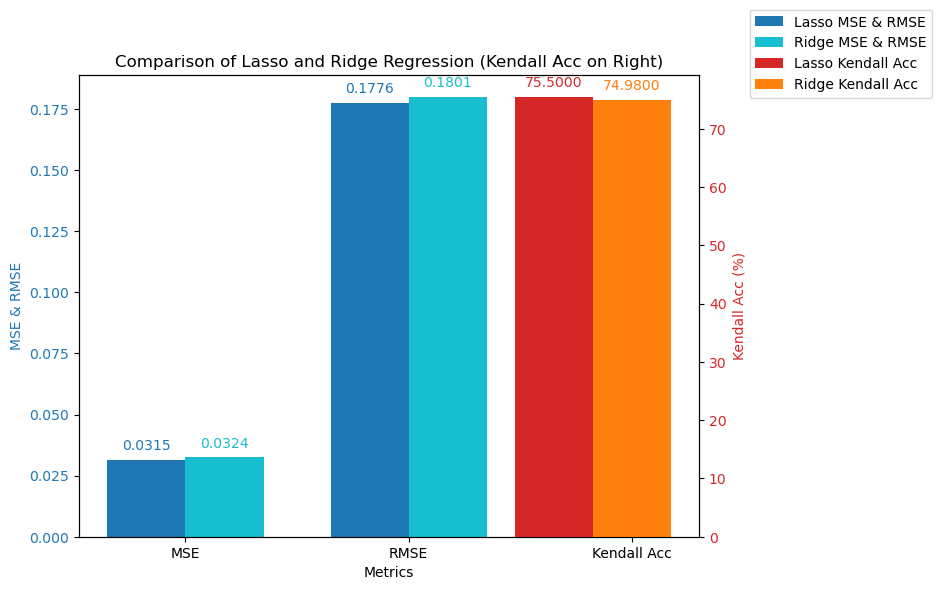

In [28]:
# Define metrics for comparison
metrics = ["MSE", "RMSE", "Kendall Acc"]
lasso_values = [mse_lasso, rmse_lasso, Probability]  # LASSO model performance values
ridge_values = [mse_ridge, rmse_ridge, ridge_acc]  # Ridge model performance values

x = np.arange(len(metrics))  # Create x-axis positions
width = 0.35  # Width of the bars

fig, ax1 = plt.subplots(figsize=(8, 6))

# Left y-axis (for MSE & RMSE)
ax1.set_xlabel("Metrics")
ax1.set_ylabel("MSE & RMSE", color="tab:blue")
bars1 = ax1.bar(x[:2] - width/2, lasso_values[:2], width, label="Lasso MSE & RMSE", color="tab:blue")
bars2 = ax1.bar(x[:2] + width/2, ridge_values[:2], width, label="Ridge MSE & RMSE", color="tab:cyan")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Right y-axis (for Kendall Accuracy)
ax2 = ax1.twinx()  # Create a twin axis sharing the same x-axis
ax2.set_ylabel("Kendall Acc (%)", color="tab:red")
bars3 = ax2.bar([x[2] - width], [lasso_values[2]], width, label="Lasso Kendall Acc", color="tab:red", align='center')
bars4 = ax2.bar([x[2]], [ridge_values[2]], width, label="Ridge Kendall Acc", color="tab:orange", align='center')
ax2.tick_params(axis="y", labelcolor="tab:red")

# Set x-axis labels
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)

# Adjust legend placement
fig.legend(loc="upper right", bbox_to_anchor=(1.2, 1), ncol=1, fontsize=10, frameon=True)

# Function to add value labels to bars
def add_value_labels(ax, bars, color="black"):
    """Add numerical labels above each bar."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.4f}",  # Format value to 4 decimal places
                    xy=(bar.get_x() + bar.get_width()/2, height),  # Position above bar
                    xytext=(0, 5), textcoords="offset points",
                    ha='center', va='bottom', color=color, fontsize=10)

# Add value labels to all bars
add_value_labels(ax1, bars1, "tab:blue")
add_value_labels(ax1, bars2, "tab:cyan")
add_value_labels(ax2, bars3, "tab:red")
add_value_labels(ax2, bars4, "tab:orange")

# Set title and save figure
plt.title("Comparison of Lasso and Ridge Regression (Kendall Acc on Right)")
plt.savefig("mse_kendall_comparison_fixed.png", bbox_inches="tight")  
plt.show()


In [29]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train_scaled, y_train_normalized.flatten())
y_pred_dummy = dummy.predict(X_test_scaled)
mse_dummy = mean_squared_error(y_test_normalized, y_pred_dummy)
rmse_dummy = np.sqrt(mse_dummy)
print(f"Dummy Regressor (Mean) - MSE: {mse_dummy:.4f}, RMSE: {rmse_dummy:.4f}")

Dummy Regressor (Mean) - MSE: 0.0509, RMSE: 0.2255


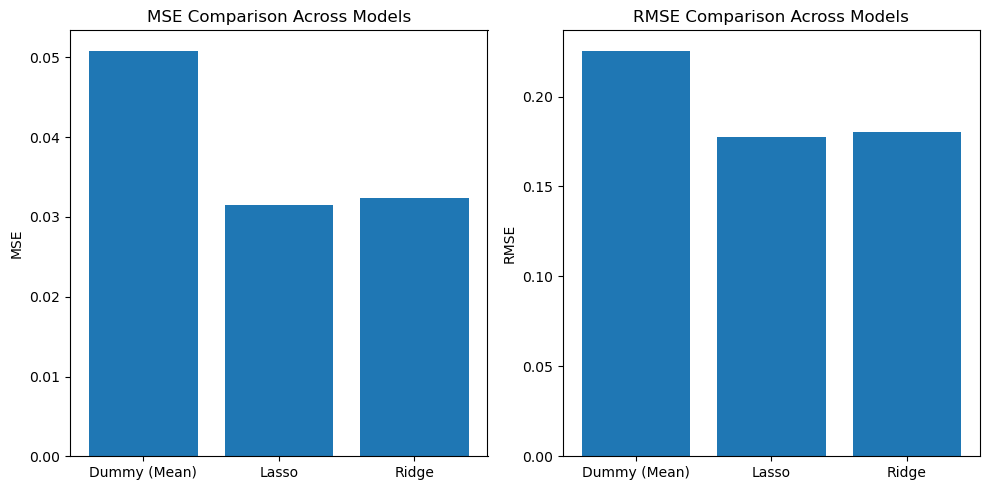


Model Performance Comparison:
Dummy (Mean) - MSE: 0.0509, RMSE: 0.2255
Lasso - MSE: 0.0315, RMSE: 0.1776
Ridge - MSE: 0.0324, RMSE: 0.1801
Improvement (Lasso vs. Dummy): MSE: 0.0184, RMSE: 0.0454
Improvement (Ridge vs. Dummy): MSE: 0.0184, RMSE: 0.0454


In [30]:
models = ['Dummy (Mean)', 'Lasso', 'Ridge']
mses = [mse_dummy, mse_lasso, mse_ridge]
rmses = [rmse_dummy, rmse_lasso, rmse_ridge]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(models, mses)
plt.title('MSE Comparison Across Models')
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
plt.bar(models, rmses)
plt.title('RMSE Comparison Across Models')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

print("\nModel Performance Comparison:")
for model, mse, rmse in zip(models, mses, rmses):
    print(f"{model} - MSE: {mse:.4f}, RMSE: {rmse:.4f}")
print(f"Improvement (Lasso vs. Dummy): MSE: {mse_dummy - mse:.4f}, RMSE: {rmse_dummy - rmse:.4f}")
print(f"Improvement (Ridge vs. Dummy): MSE: {mse_dummy - mse_ridge:.4f}, RMSE: {rmse_dummy - rmse_ridge:.4f}")